In [1]:
# All imports

import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchinfo import summary
from PIL import Image
import cv2

In [6]:
# MutiLabel CNN model Class

class MultiLabelCNN(nn.Module):
    def __init__(self, num_age, num_gen, num_eth):
        super(MultiLabelCNN, self).__init__()

        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #24
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #12
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #6
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #3
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )
        
        self.dnnModel = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
        )
        
        self.age_classifier = nn.Linear(32, num_age)
        self.gen_classifier = nn.Linear(32, num_gen)     
        self.eth_classifier = nn.Linear(32, num_eth)

    def forward(self, x):
        output = self.cnnModel(x)
        output = output.squeeze()
        output = self.dnnModel(output)
        
        age = self.age_classifier(output)
        gen = self.gen_classifier(output)
        eth = self.eth_classifier(output)

        return age, gen, eth

In [11]:
# set the coorect number of classes for each group
class_nums = {'age_num':6, 'eth_num':5, 'gen_num':2}

# Configure the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

# Initialize the MultiLabelCNN model and put on device
model = MultiLabelCNN(class_nums['age_num'], class_nums['gen_num'], class_nums['eth_num'])
model.to(device)
summary(model, (64, 1, 48, 48)) # summary of the model using torchinfo

cuda


Layer (type:depth-idx)                   Output Shape              Param #
MultiLabelCNN                            [64, 6]                   --
├─Sequential: 1-1                        [64, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 32, 48, 48]          320
│    └─MaxPool2d: 2-2                    [64, 32, 24, 24]          --
│    └─LeakyReLU: 2-3                    [64, 32, 24, 24]          --
│    └─Conv2d: 2-4                       [64, 64, 24, 24]          18,496
│    └─MaxPool2d: 2-5                    [64, 64, 12, 12]          --
│    └─LeakyReLU: 2-6                    [64, 64, 12, 12]          --
│    └─Conv2d: 2-7                       [64, 128, 12, 12]         73,856
│    └─MaxPool2d: 2-8                    [64, 128, 6, 6]           --
│    └─LeakyReLU: 2-9                    [64, 128, 6, 6]           --
│    └─Conv2d: 2-10                      [64, 256, 6, 6]           295,168
│    └─MaxPool2d: 2-11                   [64, 256, 3, 3]           --
│

In [12]:
model.load_state_dict(torch.load('../checkpoints/MultiLabelCNN_epochfinal.pth.tar')['state_dict'])
model.eval()

MultiLabelCNN(
  (cnnModel): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (dnnModel): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_f

In [13]:
# Labels on Age, Gender and Ethnicity to be predicted

age_map = ['1-2', '3-9', '10-20', '21-35', '36-60', '61-116']
gen_map = ['Male', 'Female']
eth_map = ["White", "Black", "Asian", "Indian", "Hispanic"]

In [3]:
# img_path = "./1.4_test_input/images/priyanka_chopra.jpg"
# img_path = "./1.4_test_input/images/kartik_aryan.jpg"
img_path = "../tests/images/family.jpg"

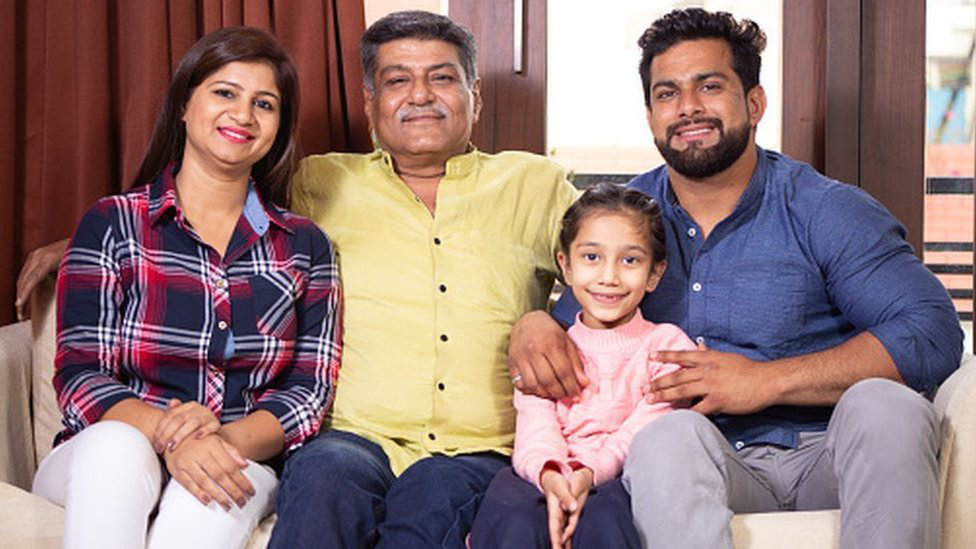

In [5]:
pil_img = Image.open(img_path)
display(pil_img)

In [ ]:
def transform_image(image_bytes):
    my_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(255),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485,],
                                            [0.229, ])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


1: Male, 36-60, Black
2: Male, 36-60, White
3: Female, 36-60, White
4: Female, 3-9, Hispanic


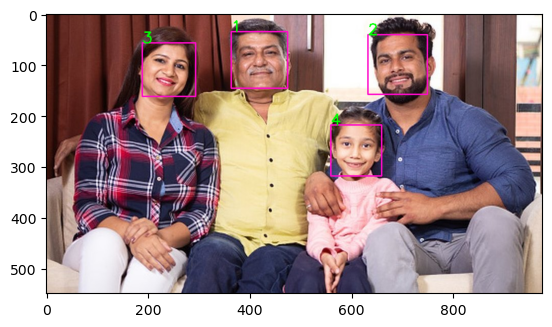

In [57]:
tfms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.49, ], [0.23])])

test_image = cv2.imread(img_path)
gray = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('../tests/cv2_cascade_classifier/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

i = 1

for (x,y,w,h) in faces:
        
        cv2.rectangle(test_image,(x,y),(x+w,y+h),(203,12,255),2)

        img_gray=gray[y:y+h,x:x+w]

        resized_img = cv2.resize(img_gray, (48, 48), interpolation = cv2.INTER_AREA)


        # unsqueeze provides the batch dimension
        img_tensor = tfms(resized_img).to('cuda').unsqueeze(0)

        with torch.no_grad():
            output1, output2, output3 = model(img_tensor)

            pred1, pred2, pred3 = torch.argmax(output1, 0), torch.argmax(output2, 0), torch.argmax(output3, 0)

            output_age = age_map[pred1.cpu()]
            output_gen = gen_map[pred2.cpu()]
            output_eth = eth_map[pred3.cpu()]

            output_str = str(i) + ": "+  output_gen + ', '+ output_age + ', '+ output_eth

            print(output_str)

            col = (0,255,0)

            cv2.putText(test_image, str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,col,2)

            i += 1

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()